In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
import pandas as pd
import os
from glob import glob
import torchvision.models as models
import sys
import librosa, librosa.display 

from pytorchtools.pytorchtools import EarlyStopping # 현재 폴더에 추가된 모듈.


if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.2  Device :  cuda


In [7]:
#시각화 패키지들
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use("ggplot")

In [8]:
# 파일 불러오기
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/sample_submission.csv')

In [9]:
# train 데이터 구경하기
train.head()

,id,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,...,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,target
0,1,-6.149463,-0.929714,9.058368,-7.017854,-2.958471,0.179233,-0.956591,-0.972401,5.956213,...,-7.026436,-6.006282,-6.005836,7.043084,21.884650,-3.064152,-5.247552,-6.026107,-11.990822,1
1,2,-2.238836,-1.003511,5.098079,-10.880357,-0.804562,-2.992123,26.972724,-8.900861,-5.968298,...,-1.996714,-7.933806,-3.136773,8.774211,10.944759,9.858186,-0.969241,-3.935553,-15.892421,1
2,3,19.087934,-2.092514,0.946750,-21.831788,9.119235,17.853587,-21.069954,-15.933212,-9.016039,...,-6.889685,54.052330,-6.109238,12.154595,6.095989,-40.195088,-3.958124,-8.079537,-5.160090,0
3,4,-2.211629,-1.930904,21.888406,-3.067560,-0.240634,2.985056,-29.073369,0.200774,-1.043742,...,-2.126170,-1.035526,2.178769,10.032723,-1.010897,-3.912848,-2.980338,-12.983597,-3.001077,1
4,5,3.953852,2.964892,-36.044802,0.899838,26.930210,11.004409,-21.962423,-11.950189,-20.933785,...,-2.051761,10.917567,1.905335,-13.004707,17.169552,2.105194,3.967986,11.861657,-27.088846,2


In [10]:
# test 데이터 구경하기
test.head()

,id,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,...,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32
0,1,0.067135,5.040383,-2.965405,-12.952880,-1.938465,-10.997802,1.853669,21.077862,7.963131,...,8.128448,5.871833,1.889536,-3.926719,0.929041,4.999071,-7.963270,4.044370,-1.993315,10.855771
1,2,6.890655,-12.010728,24.881907,38.943245,-4.757496,5.926453,7.923851,3.925545,4.012127,...,-7.941582,-27.106928,-16.940167,-11.169073,0.202975,6.846631,7.911875,-2.852819,56.028042,52.967175
2,3,-4.809695,0.962863,-1.893647,-6.168084,-3.948282,0.977219,12.960620,-9.048958,5.969053,...,-0.895094,-7.984137,-0.025761,2.981749,4.948704,-10.841968,-4.860024,-6.917495,2.842422,-3.081374
3,4,0.018158,-3.993114,12.001667,22.960746,-2.121793,-6.002385,2.173744,1.045248,1.073869,...,-10.084452,2.828070,0.903349,5.156367,40.827713,-1.160840,-1.215552,0.037914,-24.968873,-7.148603
4,5,-7.841592,-2.129997,7.872448,-8.953428,28.080007,-5.019895,-10.922551,-15.045833,-56.981894,...,-2.000975,-23.942689,-6.741350,0.831967,11.905613,3.106004,46.899363,3.001353,-17.881074,-6.882390


In [11]:
# 데이터 차원 확인하기
print('train : ',train.shape)
print("test : ", test.shape)

train :  (2335, 34)
test :  (9343, 33)


In [12]:
print("train 중복 여부 : ",train.duplicated().all() )
print("test 중복 여부 : ",train.duplicated().all() )

train 중복 여부 :  False
test 중복 여부 :  False


In [13]:
# train 데이터의 data type과 결측값이 있는지 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2335 entries, 0 to 2334
Data columns (total 34 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         2335 non-null   int64  
 1   sensor_1   2335 non-null   float64
 2   sensor_2   2335 non-null   float64
 3   sensor_3   2335 non-null   float64
 4   sensor_4   2335 non-null   float64
 5   sensor_5   2335 non-null   float64
 6   sensor_6   2335 non-null   float64
 7   sensor_7   2335 non-null   float64
 8   sensor_8   2335 non-null   float64
 9   sensor_9   2335 non-null   float64
 10  sensor_10  2335 non-null   float64
 11  sensor_11  2335 non-null   float64
 12  sensor_12  2335 non-null   float64
 13  sensor_13  2335 non-null   float64
 14  sensor_14  2335 non-null   float64
 15  sensor_15  2335 non-null   float64
 16  sensor_16  2335 non-null   float64
 17  sensor_17  2335 non-null   float64
 18  sensor_18  2335 non-null   float64
 19  sensor_19  2335 non-null   float64
 20  sensor_2

In [14]:
#train 데이터에서 id는 빼고 시각화
data = train.drop('id',axis = 1)

In [15]:
data.describe()
#이미 0을 중심으로 뭉쳐있음을 파악할 수 있다.
# x- mean 정도는 수행한 것으로 보인다. 표준편차로만 나눠주면 표준화가 될듯하다.

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,...,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,target
count,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,...,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000
mean,-1.122174,-1.024673,-0.672769,-0.147724,-0.327494,-0.423462,0.676275,-0.936019,-0.797432,-0.704585,...,-0.356441,-0.927744,-0.589060,-0.081374,-0.370812,-0.726941,-0.809534,-0.495062,-0.743585,1.523340
std,11.486353,7.399859,26.519159,15.551500,11.461970,7.314322,26.869479,15.598104,12.015022,7.384626,...,16.531906,12.021560,7.440983,25.923355,15.541803,11.636507,7.469744,25.291238,16.300385,1.118221
min,-94.746969,-63.942094,-122.195138,-111.870691,-94.147972,-70.916786,-105.956553,-102.965354,-81.268085,-47.937561,...,-127.797649,-99.115177,-86.193378,-105.751637,-105.890010,-74.977182,-74.006065,-121.097086,-123.876153,0.000000
25%,-4.036597,-4.031957,-14.878500,-7.116633,-3.968687,-3.957699,-13.937806,-8.053214,-4.031148,-3.983620,...,-7.980628,-4.004750,-4.001112,-14.096840,-8.004561,-3.981055,-3.988965,-13.998874,-7.873898,1.000000
50%,-0.951398,-1.015582,-0.961088,-0.890469,-0.871690,-0.804810,0.058910,-1.095551,-0.944613,-0.932964,...,-0.926120,-0.907301,-0.897015,-0.954791,-0.989293,-0.889780,-0.928504,-0.955684,-1.019547,2.000000
75%,2.895540,2.140456,13.974075,6.110973,2.970387,3.006144,13.934438,4.955494,2.235557,2.883284,...,6.002985,2.863184,2.951682,13.903783,5.922250,2.972719,2.519426,13.926128,5.121679,3.000000
max,68.876142,39.913391,127.124171,102.015561,89.059852,34.923040,120.046277,125.160611,74.101715,47.030119,...,127.161055,58.113657,59.105536,123.179253,111.137925,54.098746,35.896503,125.974107,104.959621,3.000000


In [16]:
# 각 target에 해당하는 개수
data['target'].value_counts()
# 즉 4 class 분류 문제이다.
# kfold는 필요없고, train set에 stratify만 적용하면 된다.

3    599
2    593
1    574
0    569
Name: target, dtype: int64

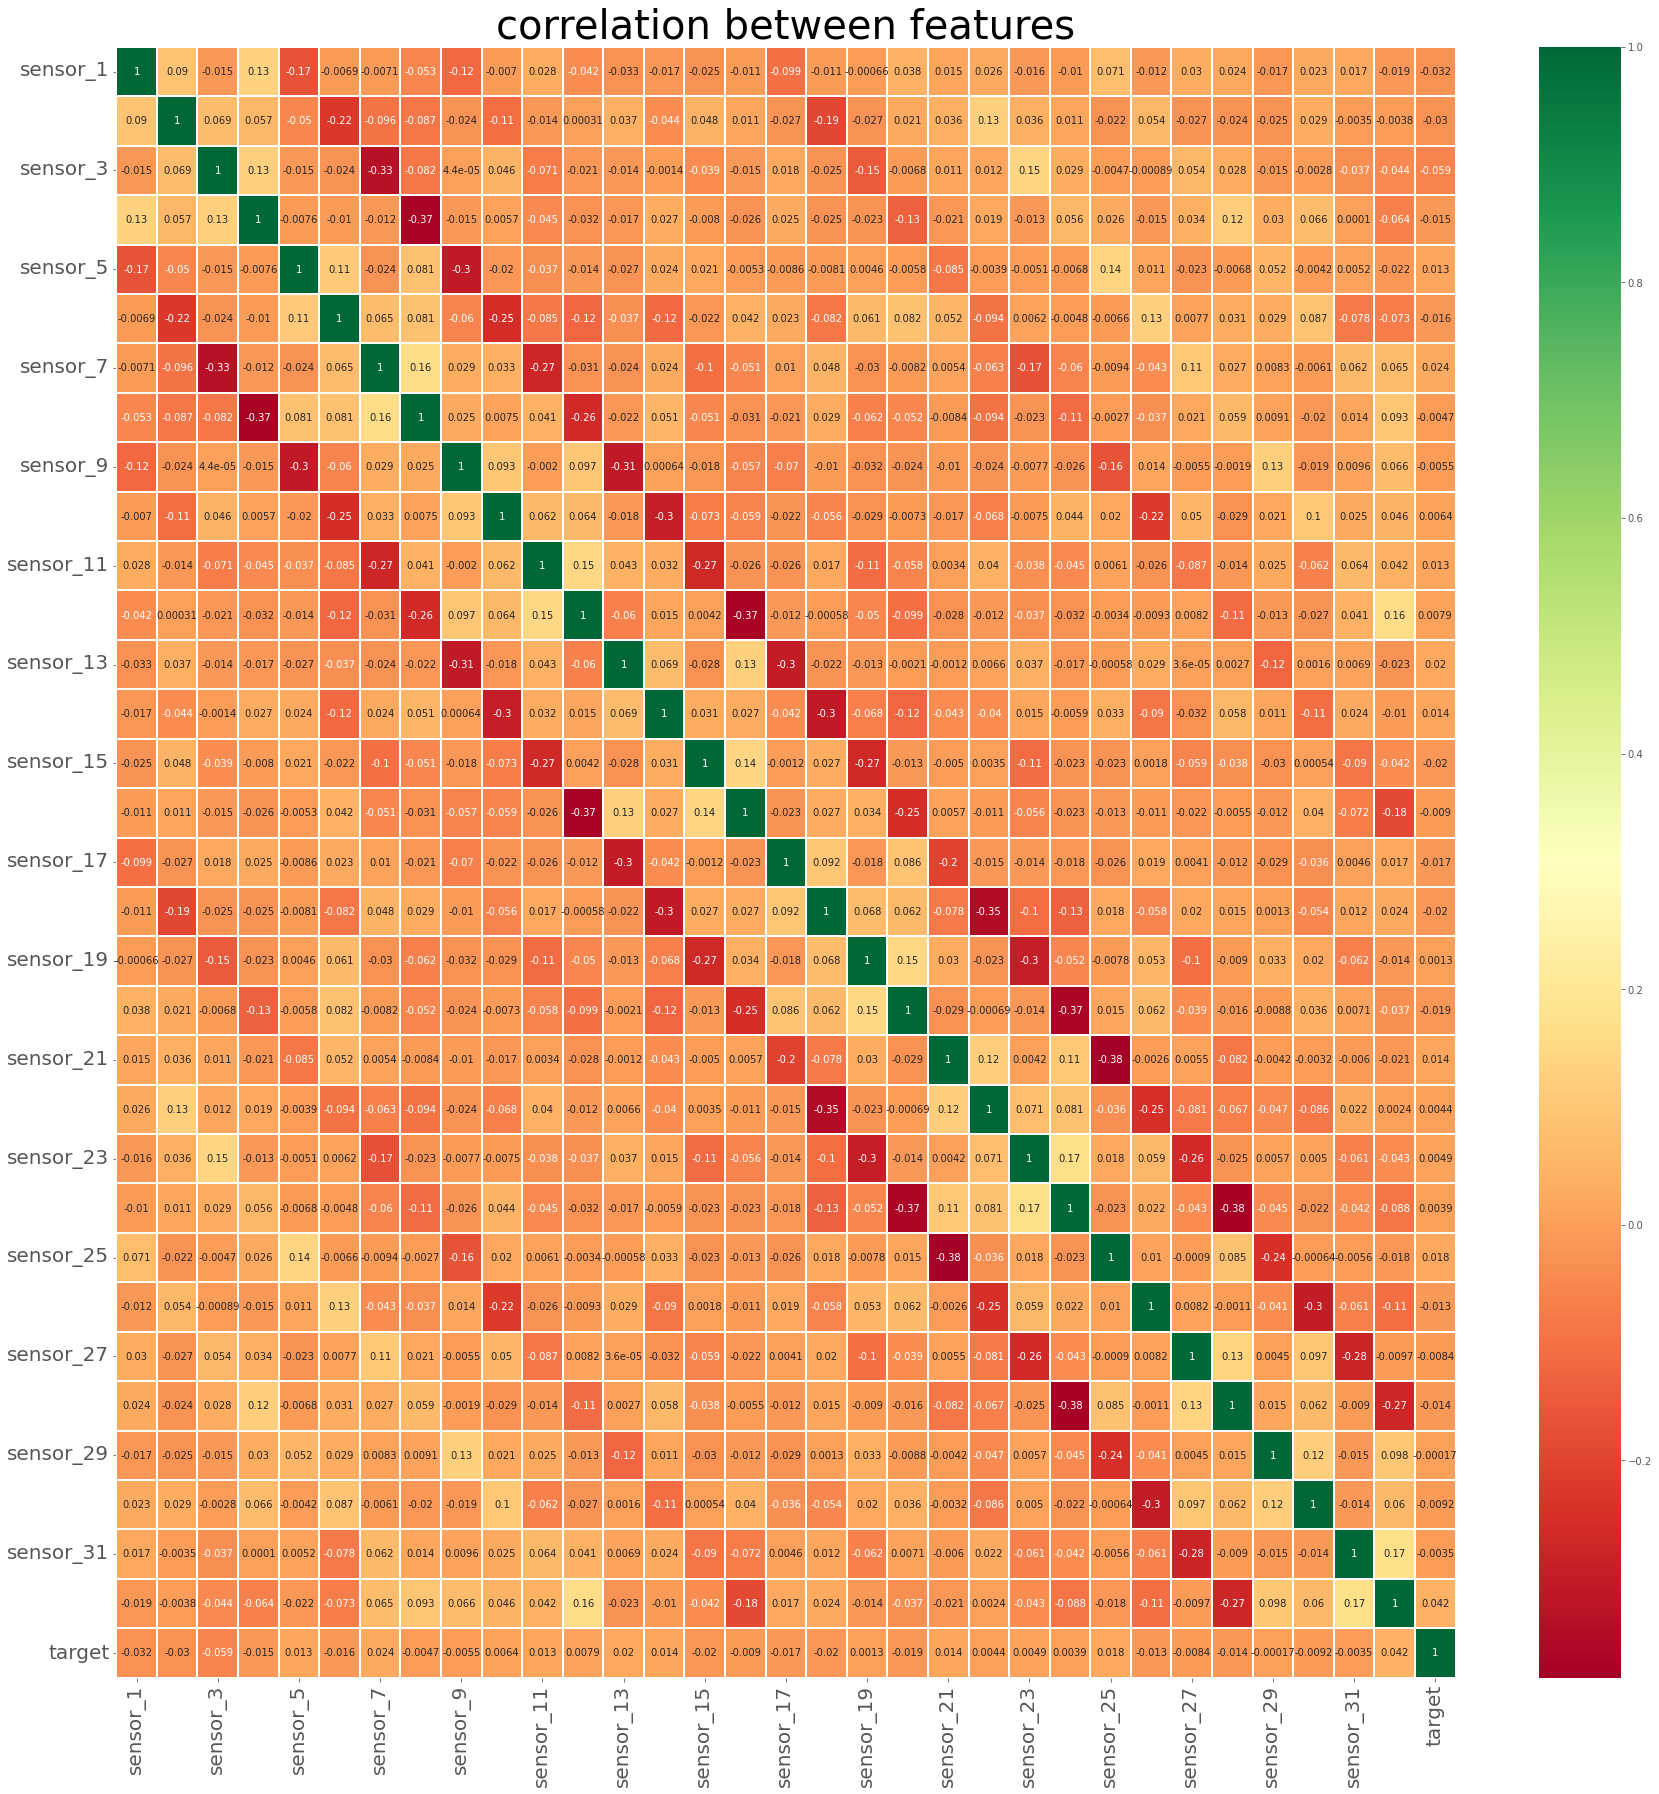

In [17]:
heatmap = sns.heatmap(data.corr(),annot = True, cmap='RdYlGn',linewidths=0.2)
fig = plt.gcf()
fig.set_size_inches(30,30)
heatmap.set_xticklabels(heatmap.get_xticklabels(),fontsize=20)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=20)

plt.title('correlation between features', fontsize=40)
plt.show()
#신기하게  senseor number -4 와 어떤 음의 상관관계를 가진다.
#상관관계를 가지기에, pca를 통해 차원 축소가 가능해보인다.
#줄이면, 간단한 svm도 가능하지 않을까?



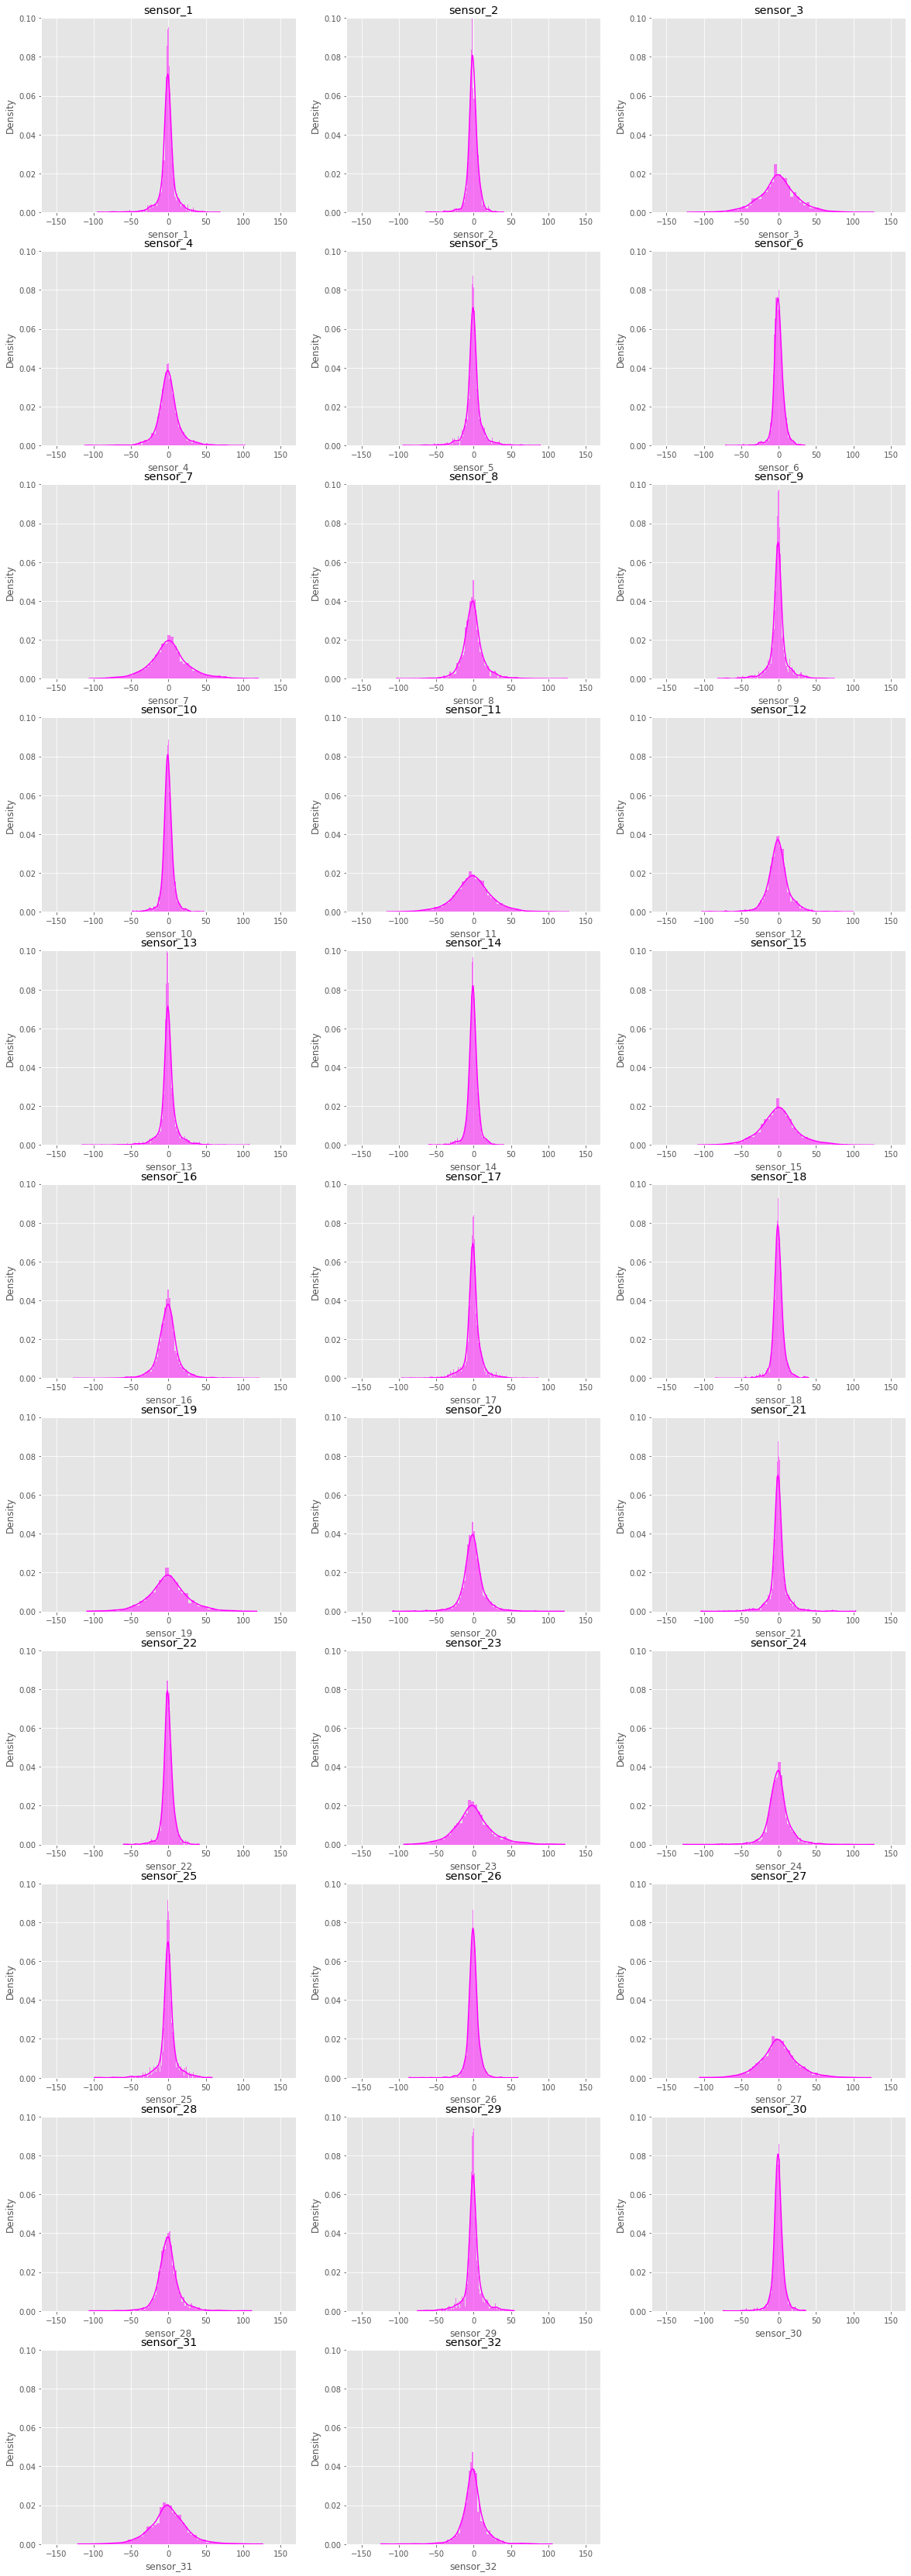

In [18]:
#각 센서별 분포그래프 그리기
feature = data.columns
plt.figure(figsize=(20,60))

for i in range(len(feature)-1):
    plt.subplot(11,3,i+1)
    plt.title(feature[i])
    plt.xlim(-170,170)
    plt.ylim(0,0.1)
    sns.histplot(data[feature[i]],color='magenta',kde=True, 
                 stat="density", linewidth=0)
plt.show()



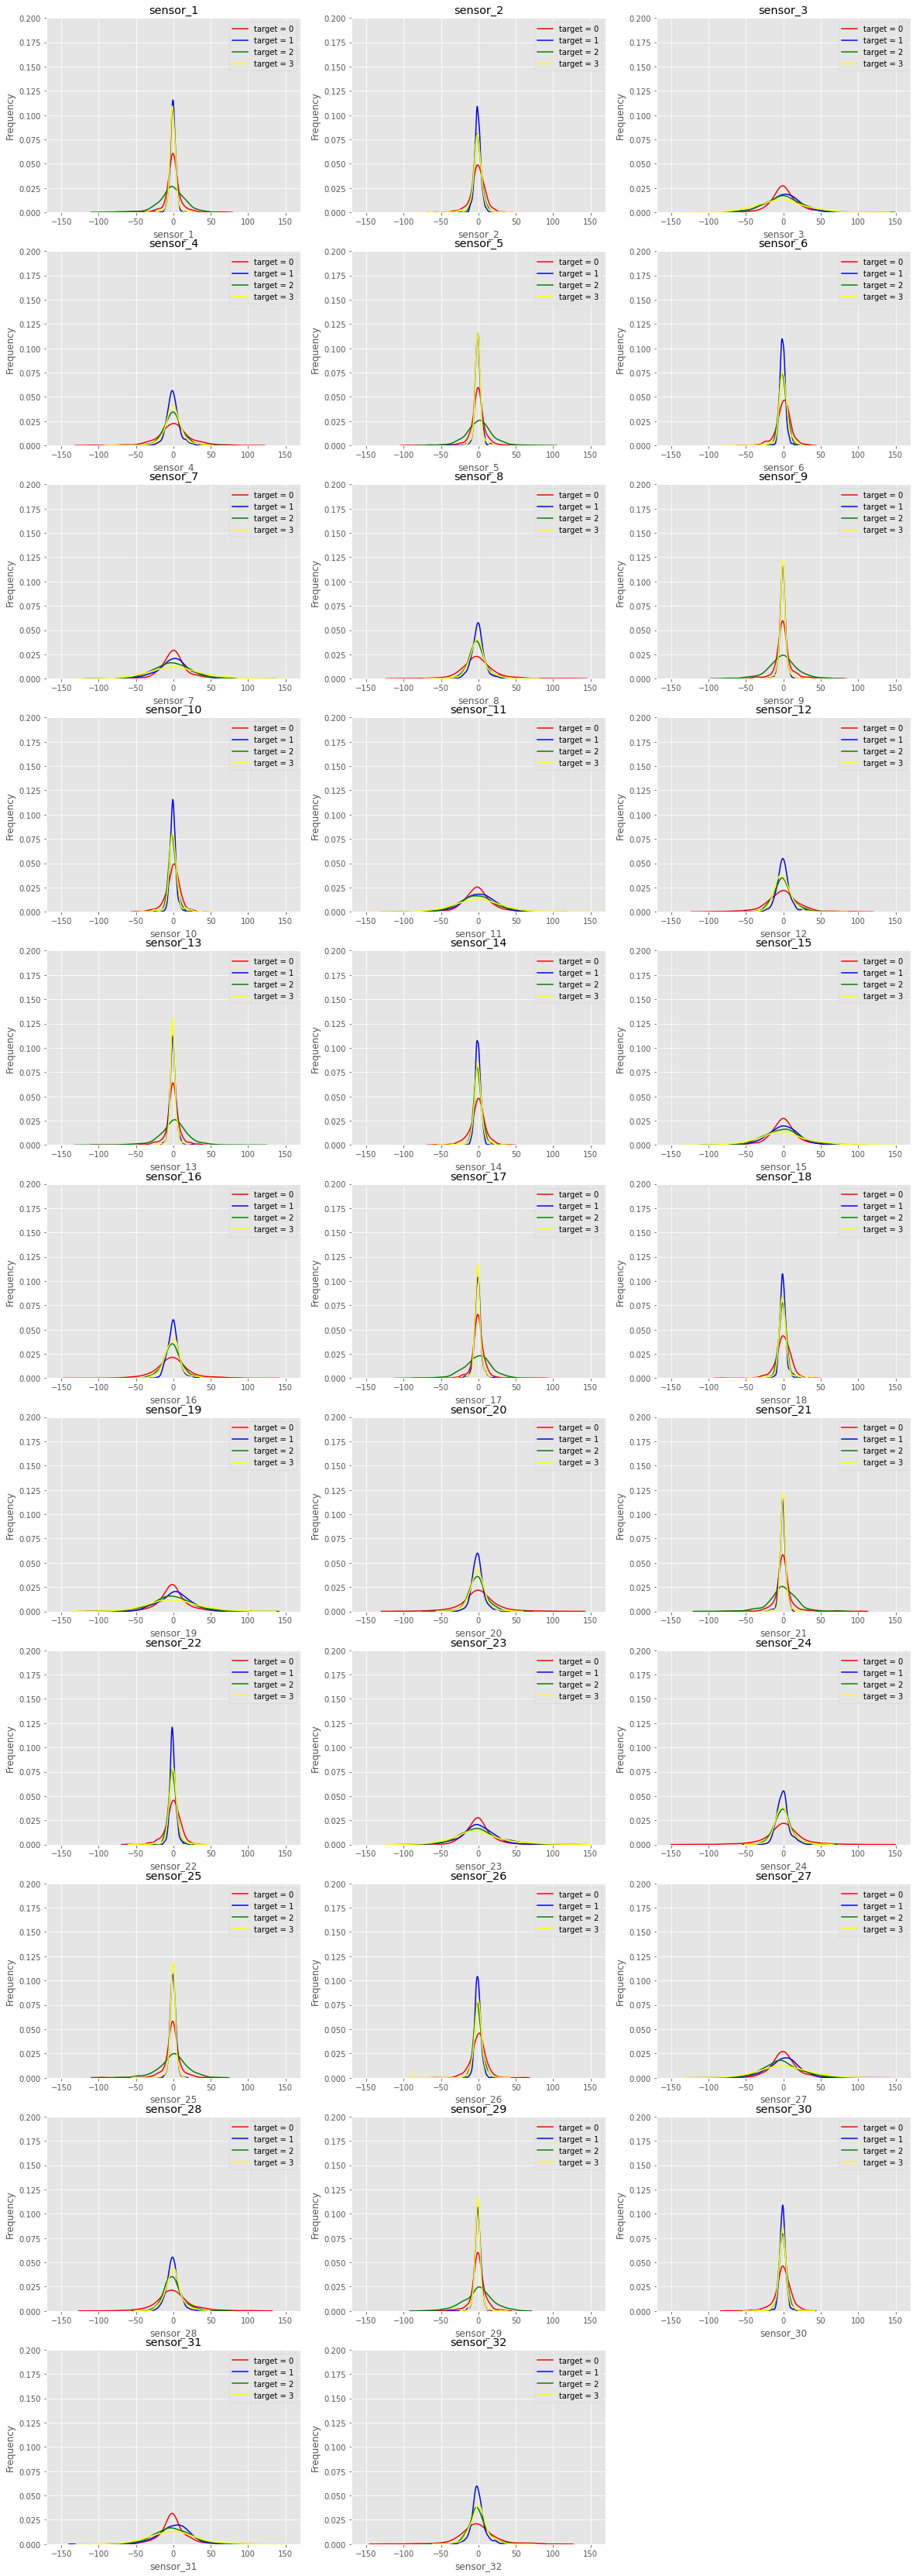

In [19]:
# 각 센서별 커널밀도함수 그리기
feature = data.columns
plt.figure(figsize=(20,60))

for i in range(len(feature)-1):
    plt.subplot(11,3,i+1)
    plt.title(feature[i])

    g = sns.kdeplot(data[feature[i]][(data['target'] == 0)], color="Red")
    g = sns.kdeplot(data[feature[i]][(data['target'] == 1)], ax =g, color="Blue")
    g = sns.kdeplot(data[feature[i]][(data['target'] == 2)], ax =g, color="green")
    g = sns.kdeplot(data[feature[i]][(data['target'] == 3)], ax =g, color="yellow")

    g.set_xlabel(feature[i])
    g.set_ylabel("Frequency")
    
    plt.xlim(-170,170)
    plt.ylim(0,0.2)
    g = g.legend(["target = 0","target = 1","target = 2","target = 3"])

plt.show()

# 데이터 가공

- 스케일러 참조:  https://mkjjo.github.io/python/2019/01/10/scaler.html

## 표준화 해보기

In [20]:
#데이터 표준화 해주기
data_new = data.copy()

for col in data:
    if col == 'target':
        continue
    data_new[col]=data[col]/data[col].std()

In [21]:
test_new = test.copy()
for col in test:
    if col == 'id':
        continue
    test_new[col]=test[col]/test[col].std()

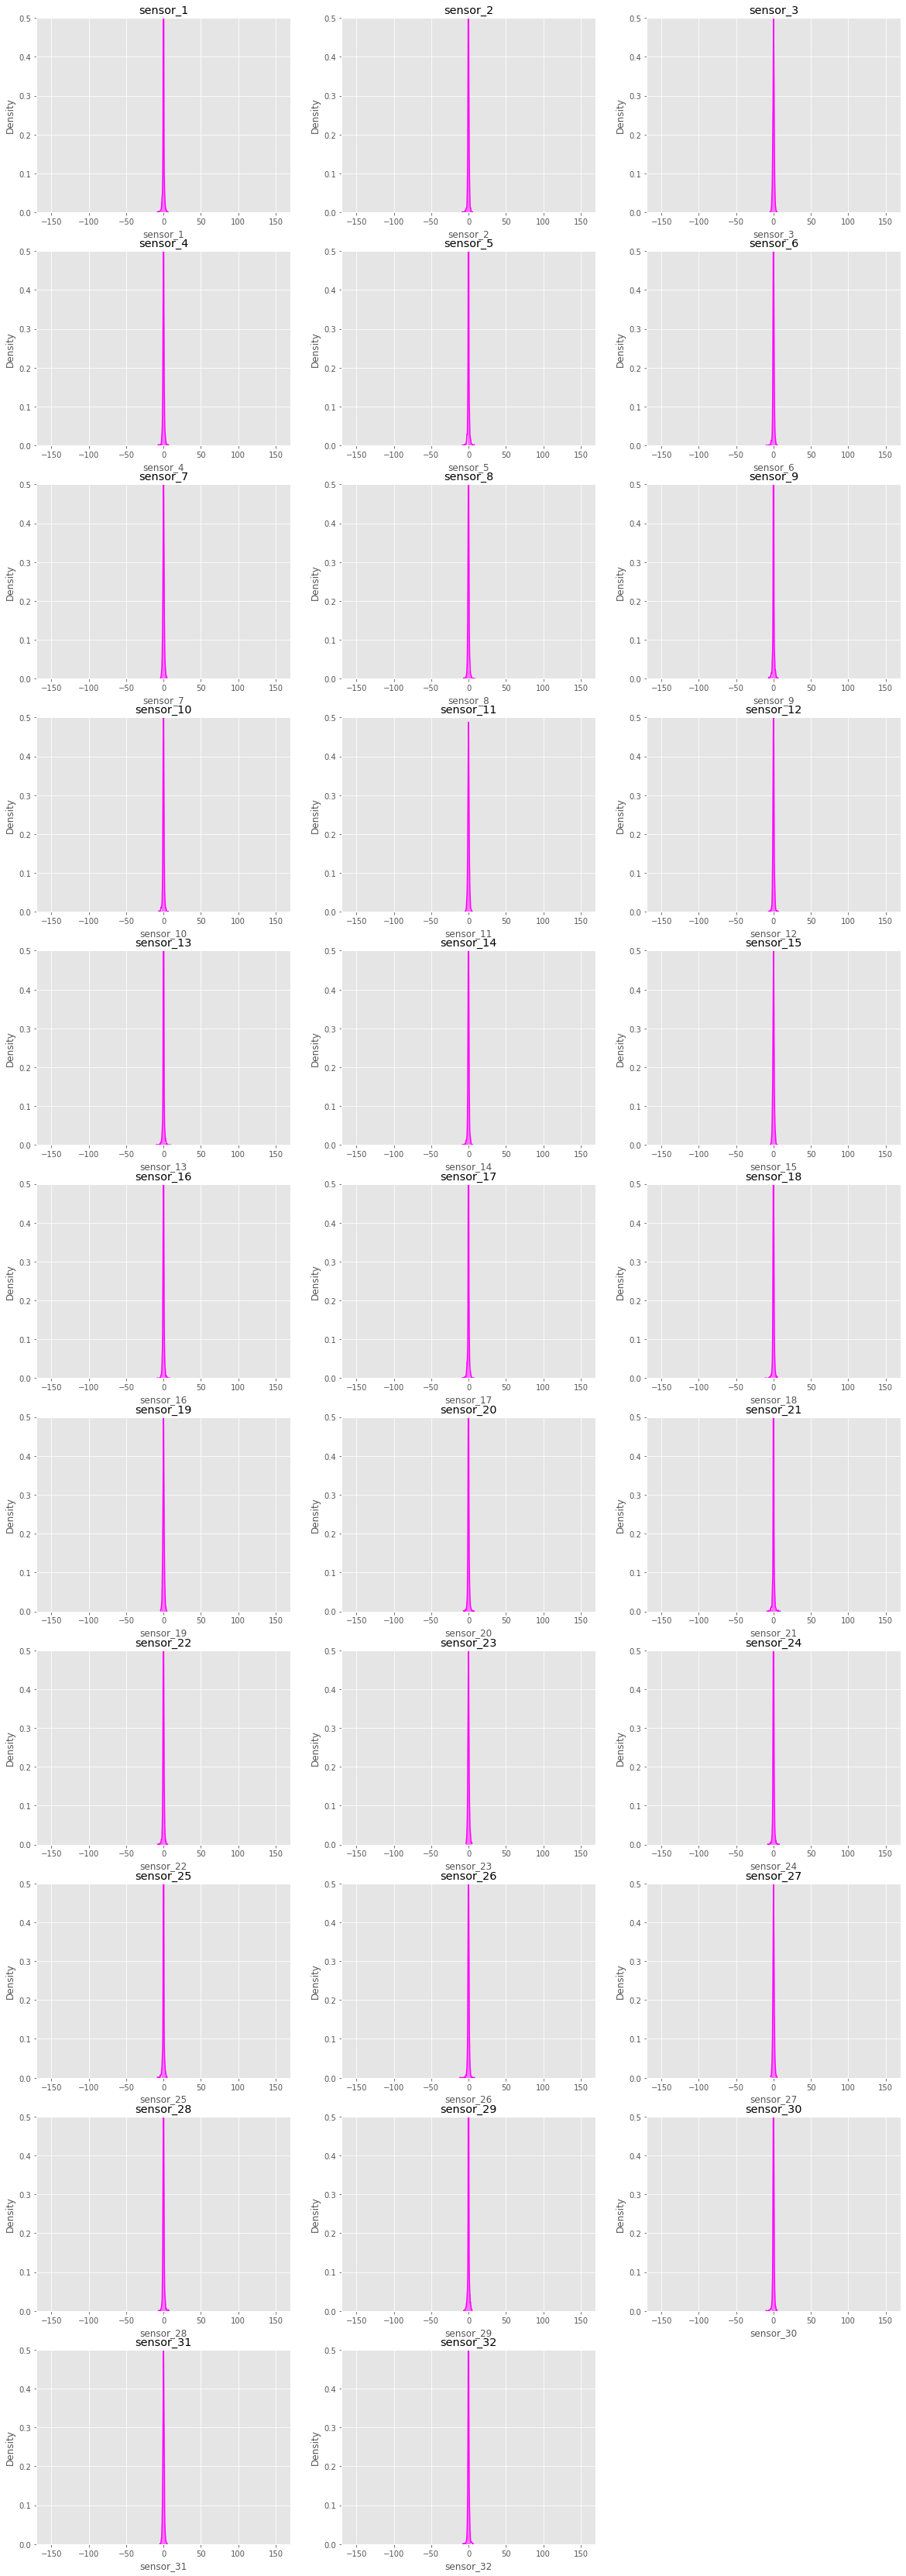

In [22]:
#표준화 후,각 센서별 분포그래프 그리기
feature = data.columns
plt.figure(figsize=(20,60))

for i in range(len(feature)-1):
    plt.subplot(11,3,i+1)
    plt.title(feature[i])
    plt.xlim(-170,170)
    plt.ylim(0,0.5)
    sns.histplot(data_new[feature[i]],color='magenta',kde=True, 
                 stat="density", linewidth=0)
plt.show()

#데이터 대부분 0에 위치하게되서, 표준화는 좋은것이 아닌것 같다.
#어떤 변환이 필요할까
#0~1 min-max normalization은 하기에는 극단값이 커보인다.


## min max normalization 해보기

In [106]:
data_new = data.copy()

In [107]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(data_new)
print(scaler.n_samples_seen_, scaler.data_min_, scaler.data_max_, scaler.feature_range)

2335 [ -94.74696895  -63.94209363 -122.1951375  -111.8706909   -94.14797204
  -70.91678577 -105.9565528  -102.9653542   -81.26808546  -47.9375611
 -115.9436932  -102.9162074  -115.0533728   -59.68943386 -107.9853855
 -126.950747    -95.95685274  -83.85421281 -108.9642702  -108.0943043
 -103.8769363   -59.99300147  -93.17127496 -127.797649    -99.11517683
  -86.19337808 -105.7516365  -105.8900098   -74.97718156  -74.00606492
 -121.0970861  -123.8761528     0.        ] [ 68.8761415   39.91339071 127.1241707  102.015561    89.05985213
  34.92304021 120.0462769  125.1606106   74.10171543  47.03011906
 127.1104187   99.93233099 107.9100409   40.02687827 126.9819073
 120.9748804   85.95204996  39.99340796 117.9342002  121.0260423
 102.8825685   40.91774149 121.959404   127.1610552   58.1136572
  59.10553647 123.179253   111.1379249   54.09874557  35.89650314
 125.9741066  104.9596215    3.        ] (0, 1)


In [108]:
data_new = scaler.transform(data_new)

In [109]:
data_new= pd.DataFrame(data_new,columns = data.columns)

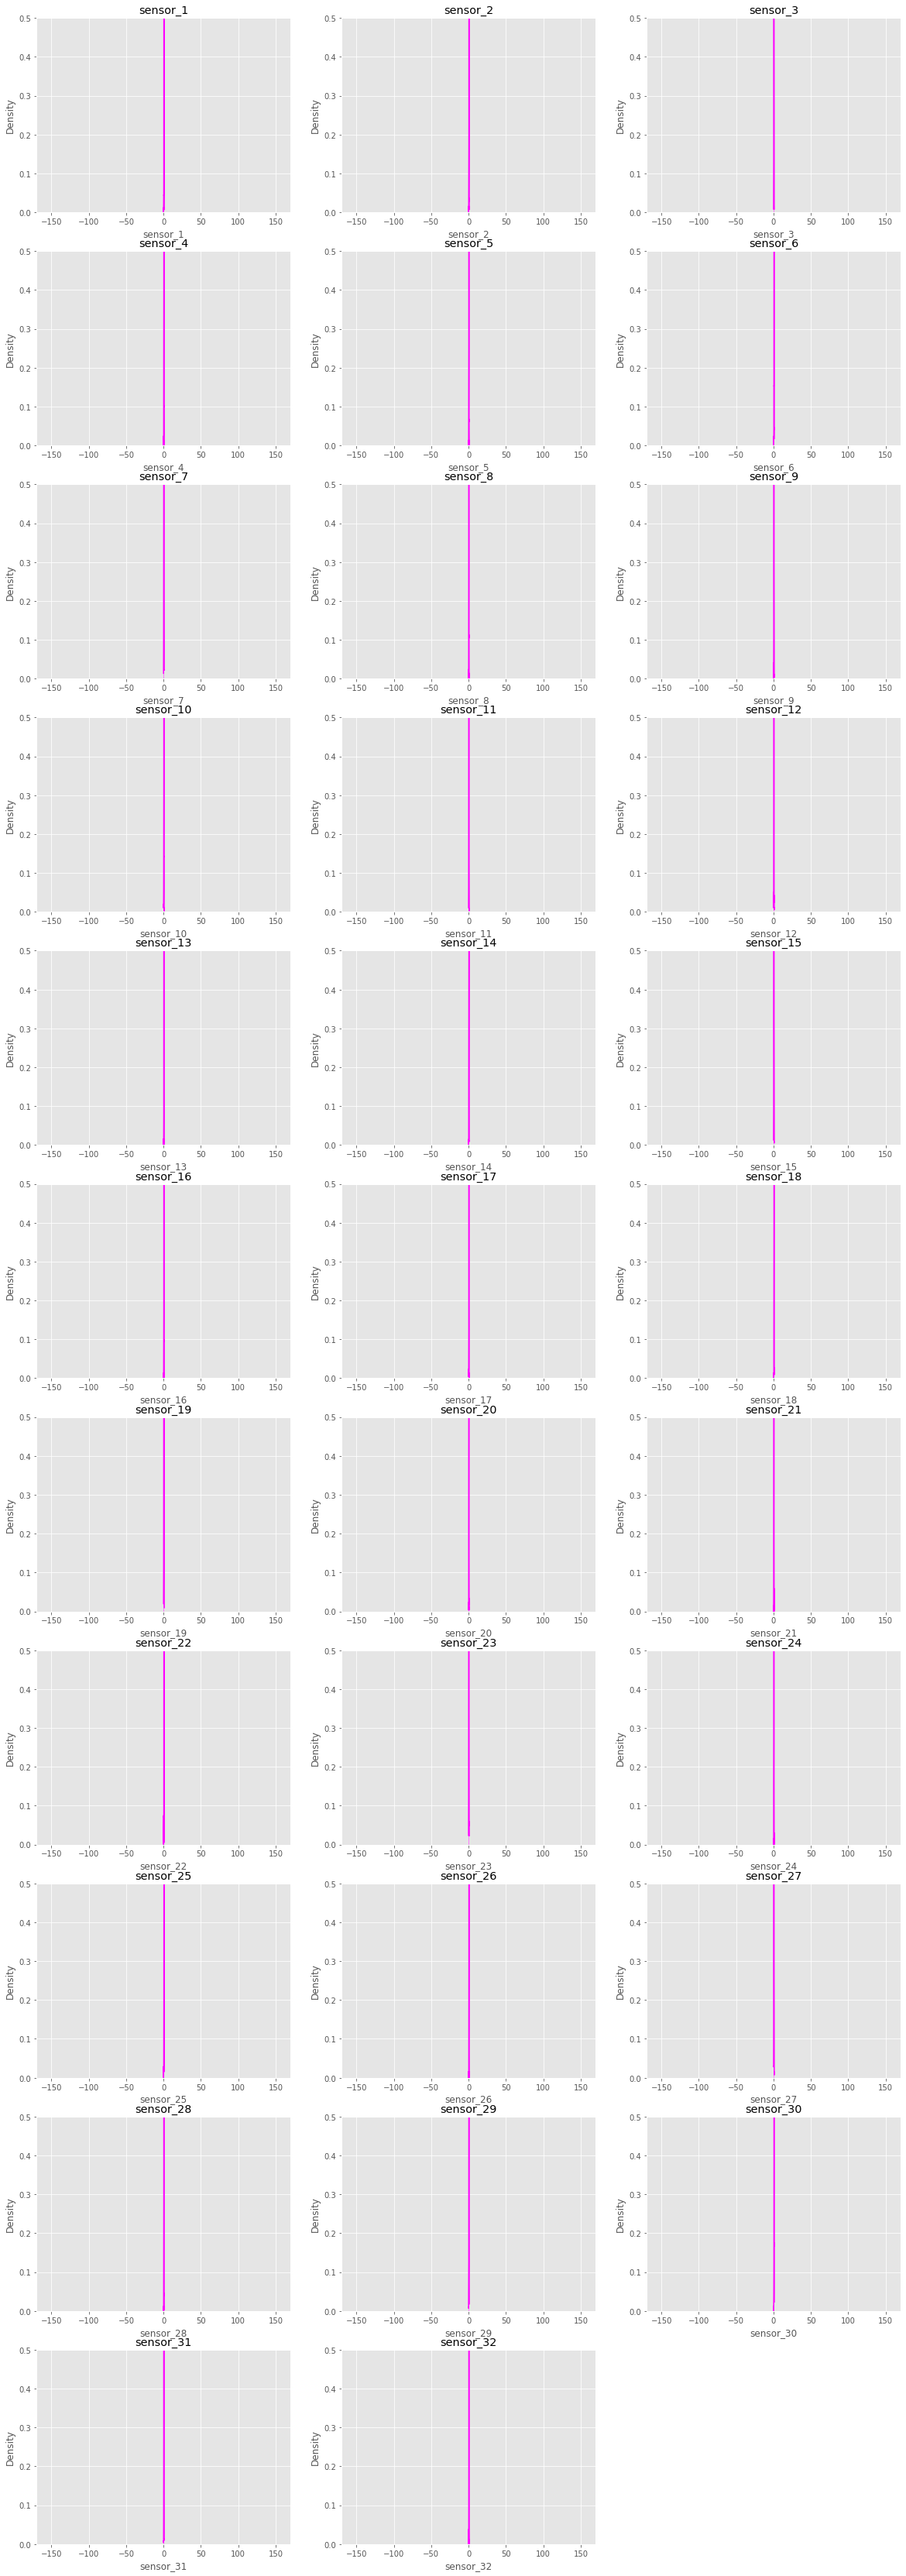

In [97]:
#표준화 후,각 센서별 분포그래프 그리기
feature = data.columns
plt.figure(figsize=(20,60))

for i in range(len(feature)-1):
    plt.subplot(11,3,i+1)
    plt.title(feature[i])
    plt.xlim(-170,170)
    plt.ylim(0,0.5)
    sns.histplot(data_new[feature[i]],color='magenta',kde=True, 
                 stat="density", linewidth=0)
plt.show()

#0~1 min-max normalization은 하기에는 극단값이 커보인다.
#결과적으로 분포를 확인할 수 없는 모습이 됬다.


## robust scaler

중앙값과 iqr을 사용한다.

In [103]:
from sklearn.preprocessing import RobustScaler
robustScaler = RobustScaler()

print(robustScaler.fit(data_new))
train_data_robustScaled = robustScaler.transform(data_new)
data_new= pd.DataFrame(data_new,columns = data.columns)

RobustScaler()


In [104]:
data_new

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,...,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,target
0,0.541473,0.606731,0.526447,0.490227,0.497738,0.671732,0.464596,0.447091,0.561398,0.548431,...,0.473689,0.592187,0.551880,0.492702,0.588748,0.557137,0.625632,0.465740,0.488933,0.333333
1,0.565373,0.606021,0.510563,0.472168,0.509495,0.641768,0.588175,0.412336,0.484649,0.462025,...,0.493417,0.579928,0.571626,0.500264,0.538340,0.657252,0.664560,0.474202,0.471883,0.333333
2,0.695714,0.595535,0.493912,0.420966,0.563662,0.838724,0.375600,0.381509,0.465033,0.441859,...,0.474226,0.974169,0.551168,0.515030,0.515998,0.269470,0.637364,0.457429,0.518783,0.000000
3,0.565540,0.597091,0.577908,0.508696,0.512573,0.698242,0.340187,0.452233,0.516345,0.526889,...,0.492909,0.623802,0.608209,0.505761,0.483252,0.550562,0.646261,0.437580,0.528218,0.333333
4,0.603221,0.644232,0.345542,0.527245,0.660879,0.774011,0.371651,0.398969,0.388327,0.462653,...,0.493201,0.699825,0.606327,0.405131,0.567022,0.597186,0.709483,0.538139,0.422955,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2330,0.554787,1.000000,0.554429,0.433889,0.557887,0.000000,0.292118,0.507612,0.381864,0.662126,...,0.513354,0.598874,0.516773,0.296545,0.631068,0.549135,0.554226,0.469285,0.576363,1.000000
2331,0.560650,0.576587,0.485919,0.542573,0.502952,0.642686,0.456586,0.323796,0.495972,0.454299,...,0.528202,0.629533,0.587247,0.566302,0.432719,0.596249,0.681492,0.606785,0.537492,1.000000
2332,0.524041,0.673318,0.457441,0.472066,0.541735,0.746888,0.614303,0.438126,0.502631,0.444495,...,0.470056,0.643423,0.553119,0.295994,0.557090,0.589866,0.572054,0.461654,0.537268,1.000000
2333,0.554683,0.644680,0.442187,0.505221,0.606023,0.621379,0.509460,0.473096,0.387885,0.484965,...,0.513330,0.643457,0.585972,0.435643,0.455309,0.535740,0.637082,0.550505,0.488484,0.333333


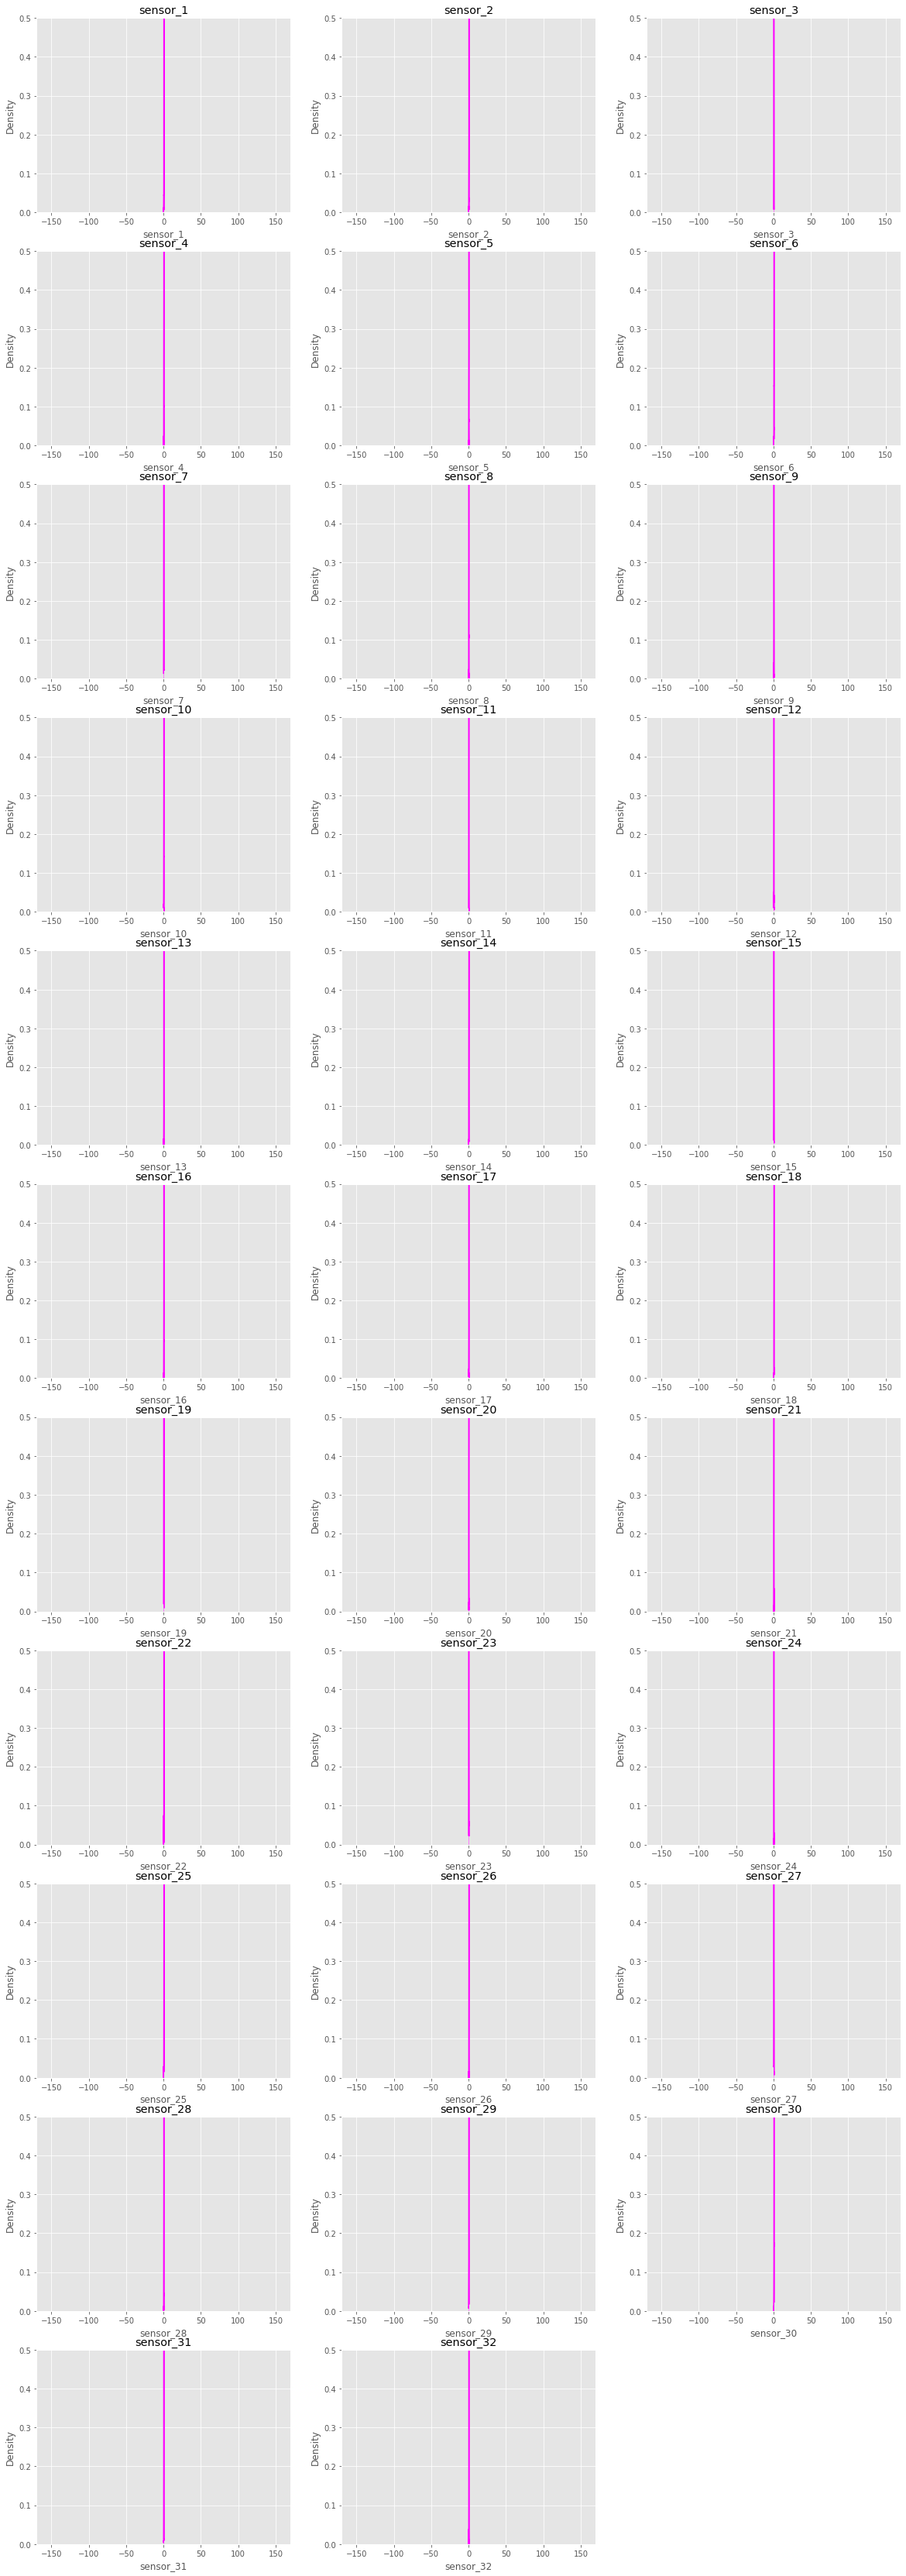

In [105]:
#표준화 후,각 센서별 분포그래프 그리기
feature = data.columns
plt.figure(figsize=(20,60))

for i in range(len(feature)-1):
    plt.subplot(11,3,i+1)
    plt.title(feature[i])
    plt.xlim(-170,170)
    plt.ylim(0,0.5)
    sns.histplot(data_new[feature[i]],color='magenta',kde=True, 
                 stat="density", linewidth=0)
plt.show()

#0~1 min-max normalization은 하기에는 극단값이 커보인다.
#결과적으로 분포를 확인할 수 없는 모습이 됬다.

#min max scaler와 비슷하다,.


### 결론.

min-max, robust는 데이터가 너무 0에 집중이 되는 것 처럼 보여서

단순 표준화가 더 좋아보인다.

In [23]:
# 데이터 출력

data_new.to_csv("./data/train_std.csv",index=False)

In [24]:
test_new.to_csv("./data/test_std.csv",index=False)